# Setup

In [2]:
import boto3
import numpy
import pandas

import config
import constants
import columns
from utils.io.s3 import download_dataframe, list_objects
from utils.validation.viz import ItemInfo, RecommendedItemInfo, show_recs_for_item

In [3]:
s3_session = boto3.session.Session()
s3_client = s3_session.client(service_name='s3', endpoint_url='https://storage.yandexcloud.net')

In [4]:
train_df = download_dataframe(s3_client, constants.S3_BUCKET, constants.DATA_PATH / 'imdb_movies.parquet')
valid_df = download_dataframe(s3_client, constants.S3_BUCKET, constants.DATA_PATH / 'relevant_titles_subsample.parquet')

# Browse data

In [5]:
train_df.head()

,title_id,poster_url,type,name,original_name,description,genre,date,rating_count,rating_value,keywords,featured_review,stars,directors,creators
0,tt0111161,https://m.media-amazon.com/images/M/MV5BNDE3OD...,Movie,Побег из Шоушенка,The Shawshank Redemption,"Over the course of several years, two convicts...",[Drama],1994-10-14,2755277.0,9.3,"[prison, based on the works of stephen king, e...",It is no wonder that the film has such a high ...,"[Tim Robbins, Morgan Freeman, Bob Gunton]",[Frank Darabont],"[Stephen King, Frank Darabont]"
1,tt0068646,https://m.media-amazon.com/images/M/MV5BM2MyNj...,Movie,Крестный отец,The Godfather,"Don Vito Corleone, head of a mafia family, dec...","[Crime, Drama]",1972-03-24,1917037.0,9.2,"[mafia, patriarch, crime family, organized cri...",I love this movie and all of the GF movies. I ...,"[Marlon Brando, Al Pacino, James Caan]",[Francis Ford Coppola],"[Mario Puzo, Francis Ford Coppola]"
2,tt0468569,https://m.media-amazon.com/images/M/MV5BMTMxNT...,Movie,Тёмный рыцарь,The Dark Knight,When the menace known as the Joker wreaks havo...,"[Action, Crime, Drama]",2008-08-14,2728169.0,9.0,"[dc comics, psychopath, moral dilemma, superhe...","If someone else acted as Joker, I would give t...","[Christian Bale, Heath Ledger, Aaron Eckhart]",[Christopher Nolan],"[Jonathan Nolan, Christopher Nolan, David S. G..."
3,tt0050083,https://m.media-amazon.com/images/M/MV5BMWU4N2...,Movie,12 разгневанных мужчин,12 Angry Men,The jury in a New York City murder trial is fr...,"[Crime, Drama]",1961-11-13,816234.0,9.0,"[jury, dialogue driven, courtroom, trial, jury...",&apos;12 Angry Men&apos; is an outstanding fil...,"[Henry Fonda, Lee J. Cobb, Martin Balsam]",[Sidney Lumet],[Reginald Rose]
4,tt0071562,https://m.media-amazon.com/images/M/MV5BMWMwMG...,Movie,Крестный отец 2,The Godfather Part II,The early life and career of Vito Corleone in ...,"[Crime, Drama]",1974-12-18,1305122.0,9.0,"[revenge, 1950s, corrupt politician, cuban rev...",The original Godfather is a brilliant work. It...,"[Al Pacino, Robert De Niro, Robert Duvall]",[Francis Ford Coppola],"[Francis Ford Coppola, Mario Puzo]"


In [6]:
train_df['featured_review'].head()

0    It is no wonder that the film has such a high ...
1    I love this movie and all of the GF movies. I ...
2    If someone else acted as Joker, I would give t...
3    &apos;12 Angry Men&apos; is an outstanding fil...
4    The original Godfather is a brilliant work. It...
Name: featured_review, dtype: object

In [7]:
train_df['featured_review'].describe()

count                                                  9751
unique                                                 9751
top       It is no wonder that the film has such a high ...
freq                                                      1
Name: featured_review, dtype: object

In [8]:
train_df['featured_review'].dropna().map(len).describe()

count     9751.000000
mean      1390.982258
std       1142.464765
min         50.000000
25%        656.500000
50%       1040.000000
75%       1799.000000
max      11702.000000
Name: featured_review, dtype: float64

In [9]:
train_df['featured_review'].dropna().str.split(' ').map(len).describe()

count    9751.000000
mean      235.965747
std       190.627278
min         7.000000
25%       114.000000
50%       178.000000
75%       303.500000
max      2019.000000
Name: featured_review, dtype: float64

In [10]:
config.pipelines['similarity']

Pipeline(steps=[('vectorizer',
                 ColumnTransformer(transformers=[('keywords',
                                                  Pipeline(steps=[('vectorizer',
                                                                   CountVectorizer(lowercase=False,
                                                                                   token_pattern=None,
                                                                                   tokenizer=<function simple_vectorizer.<locals>.<lambda> at 0x7f361012b670>)),
                                                                  ('normalizer',
                                                                   Normalizer())]),
                                                  'keywords'),
                                                 ('stars',
                                                  Pipeline(steps=[('vectorizer',
                                                                   CountVectorizer(lowercase=False,
                                                                                   token_pa...
                                                  'genre'),
                                                 ('description',
                                                  Pipeline(steps=[('tokenizer',
                                                                   FunctionTransformer(func=functools.partial(<function function_1d_wrapper at 0x7f3610e570d0>, func1d=<function document_tokenize at 0x7f36112e7670>, dtype=<class 'numpy.object_'>))),
                                                                  ('embedding',
                                                                   Word2VecVectorizer()),
                                                                  ('normalizer',
                                                                   Normalizer())]),
                                                  'description')])),
                ('recommender', SimilarItemsContentRecommender())])

# Show recommendations

In [22]:
pipeline_id = 'similarity'

In [23]:
list_objects(s3_client, constants.S3_BUCKET, constants.SUBMISSION_PATH / pipeline_id)

['hardml/recsys/lesson2/submissions/similarity/20240206T064200.parquet',
 'hardml/recsys/lesson2/submissions/similarity/20240206T064930.parquet',
 'hardml/recsys/lesson2/submissions/similarity/20240207T181905.parquet',
 'hardml/recsys/lesson2/submissions/similarity/20240207T182935.parquet',
 'hardml/recsys/lesson2/submissions/similarity/20240207T190422.parquet',
 'hardml/recsys/lesson2/submissions/similarity/20240207T191302.parquet',
 'hardml/recsys/lesson2/submissions/similarity/20240207T191443.parquet',
 'hardml/recsys/lesson2/submissions/similarity/20240207T192302.parquet',
 'hardml/recsys/lesson2/submissions/similarity/20240209T182912.parquet',
 'hardml/recsys/lesson2/submissions/similarity/20240209T183202.parquet',
 'hardml/recsys/lesson2/submissions/similarity/20240209T184639.parquet']

In [24]:
submission_df = download_dataframe(s3_client,
                                   constants.S3_BUCKET,
                                   constants.SUBMISSION_PATH / pipeline_id / '20240209T184639.parquet')
submission_df.head()

,title_id,recs
0,tt0111161,"[tt26228426, tt0108941, tt1870479, tt9000224, ..."
1,tt0068646,"[tt0099674, tt5783646, tt2544182, tt0071562, t..."
2,tt0468569,"[tt0372784, tt1345836, tt0482571, tt5783646, t..."
3,tt0050083,"[tt1872194, tt0050051, tt11298328, tt13471702,..."
4,tt0071562,"[tt0099674, tt0068646, tt4882708, tt0113277, t..."


In [25]:
base_item_id = 'tt0468569'

In [26]:
movies = train_df.set_index(columns.TITLE_ID_COLUMN).to_dict(orient='index')
len(movies)

9798

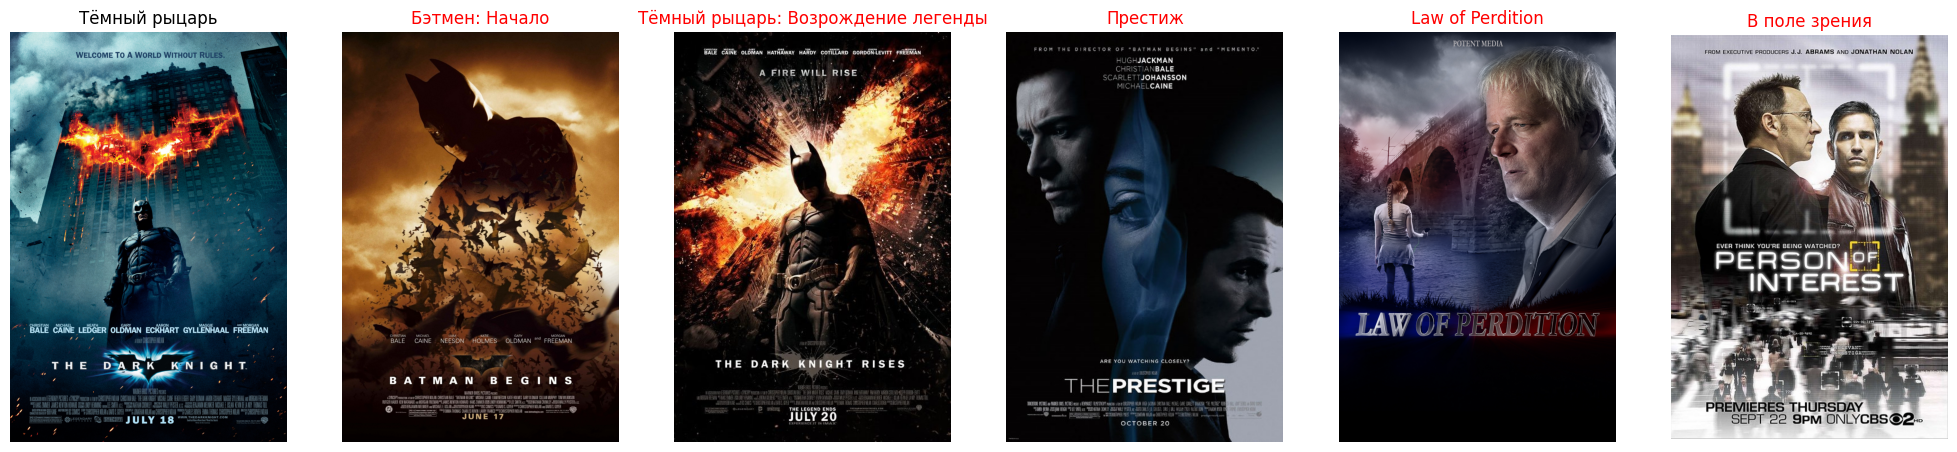

In [27]:
item_info = ItemInfo(name=movies[base_item_id]['name'],
                     image_url=movies[base_item_id]['poster_url'])

preds_rows = submission_df.set_index(columns.TITLE_ID_COLUMN).loc[base_item_id, columns.RECS_COLUMN]
recs_info = [RecommendedItemInfo(name=movies[title_id]['name'],
                                 image_url=movies[title_id]['poster_url'],
                                 in_y_true=False)
             for title_id in preds_rows[:5]]

show_recs_for_item(item_info, recs_info);